# Classifying names using character - level RNN

## Importing modules

In [1]:
from os import listdir
from os.path import isfile, join
import unicodedata
import string
import torch
import torch.nn as nn
from random import shuffle
import time
import math
import matplotlib.pyplot as plt

## Defining helper functions

Since the dataset contains names containing unicode characters, so we will first convert these characters to simple ascii.

In [2]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

Encoding a single name to a tensor of size <name_length x 1 x n_letters>

In [3]:
def nameToTensor(name):
	nameTensor = torch.zeros(len(name), 1, n_letters)
	index=0
	for letter in name:
		letterIndex = all_letters.find(letter)
		nameTensor[index][0][letterIndex]=1
		index+=1
	return nameTensor

Getting the category name from output tensor of size <n_letters x 1>

In [4]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

Function to get the minute and seconds passed considering a reference time

In [5]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Model

Recurrent neural networks (more often called RNNs) are used to deal with sequence data. A RNN unit takes some input data and a hidden state(calculated by some computation done on the previous input of the sequence) as input, and gives both an output and a hidden state as output. This output and hidden state are then again passed through the RNN unit and so on for the whole sequence.  I have used a very basic model as used in [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

<img src='model.png'/>

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Making a list of all characters expected to be present in the names

In [7]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


## Data Loading

Data is in the data/names directory where all the names of a particular language are present in language_name.txt file. First I have fetched the data and created a dictionary out of it having key as language name and all the names of that language as a list for the value of that key.
<br>Then I have made a 2D list containing all the dataset. Rows contain the name and category(language origin) of that name.<br>
For training I have used 80% of the dataset and rest for testing. 

In [8]:
dataSetPath = "data/names/"
onlyFileNames = []
for f in listdir(dataSetPath):
	if isfile(join(dataSetPath, f)):
		if f[:2]!="._":
			onlyFileNames.append(f)

dataSetComplete={}
completeFileName=""

for file in onlyFileNames:
	completeFileName = dataSetPath+file
	ofile = open(completeFileName,"r")
	currentFileData = ofile.readlines()
	currentFileData = [unicodeToAscii(x.strip()) for x in currentFileData]
	ofile.close()
	langName = file[:-4]
	dataSetComplete[langName]=currentFileData

n_languages = len(dataSetComplete)
all_categories = [s[:-4] for s in onlyFileNames]

##Converting the dataset dict to an array
wholeDataSet=[]
for category in dataSetComplete:
	for name in dataSetComplete[category]:
		oneExample = []
		oneExample.append(name)
		oneExample.append(category)
		wholeDataSet.append(oneExample)
shuffle(wholeDataSet)
# for i in range(100):
# 	print(wholeDataSet[i])

total_names = len(wholeDataSet)
num_training_examples = int((total_names*4)/5)
print(num_training_examples)
trainDataSet = wholeDataSet[:num_training_examples]
testDataSet = wholeDataSet[num_training_examples:]

16059


### Instantiating the RNN unit and specifying the Loss criterion (Negative Log Likelihood)

In [9]:
n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_languages)

criterion = nn.NLLLoss()

## Training

First I have defined a train() function inspired from [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). 

It takes a name tensor and category tensor of a particular training example and does the following tasks : 

1. It initialises the forst hidden layer for the sequence as a tensor of zeroes
2. First it deletes any accumulated gradients from the model instance
3. Sequentially forward passes each character tensor from the name tensor to the rnn unit and feeds back the hidden states
4. Calculates the loss function using the output and category tensor
5. Backpropagates the loss and calculates the gradients
6. Updates the model parameters (gradient descent)

And finally returns the output and loss value

In [10]:
def train(nameTensor, categoryTensor):
	hidden = rnn.initHidden()
	rnn.zero_grad()

	for i in range(nameTensor.size()[0]):
		output, hidden = rnn.forward(nameTensor[i], hidden)

	loss = criterion(output, categoryTensor)
	loss.backward()

	for p in rnn.parameters():
		p.data.add_(-learning_rate, p.grad.data)

	return output, loss.item()

### Specifying the hyper parameters

Along with a few other helper variables

In [11]:
learning_rate = 0.005

num_epochs=5

start = time.time()

allLosses=[]

### Training iterations

Since we have already defined the train() function, the training process becomes a lot easier now. We just have to iterate through each example, create a tensor of name from our previously defined nameToTensor() function and a tensor of category by simple one hot encoding. <br>
Then we need to find the loss and output of that example and use that loss accordingly. Losses are later used to determine whether our training is correct.
<br>It is also important to note that data should be shuffled after each epoch. This lead to increase in accuracy of about 1%.

In [12]:
for epoch in range(num_epochs):
	currentLoss = 0
	i=0
	lossesRecord=[]
	totalLoss=0
	shuffle(trainDataSet)
	for example in trainDataSet:
		categoryTensor = torch.tensor([all_categories.index(example[1])], dtype=torch.long)
		nameTensor = nameToTensor(example[0])
		output, loss = train(nameTensor, categoryTensor)
		currentLoss+=loss
		totalLoss+=loss
		i+=1
		if i%2000==0:
			print('Epoch : %d Iteration: %d Time: %s CurrentExampleLoss: %.4f TotalLoss: %.4f ' % 
				(epoch+1,i,timeSince(start), loss,totalLoss))
		if i%200==0:
			lossesRecord.append(currentLoss/200)
			currentLoss=0
	allLosses.append(lossesRecord)

Epoch : 1 Iteration: 2000 Time: 0m 3s CurrentExampleLoss: 0.4018 TotalLoss: 3708.5997 
Epoch : 1 Iteration: 4000 Time: 0m 6s CurrentExampleLoss: 3.0292 TotalLoss: 6855.3282 
Epoch : 1 Iteration: 6000 Time: 0m 10s CurrentExampleLoss: 0.1977 TotalLoss: 9836.9759 
Epoch : 1 Iteration: 8000 Time: 0m 14s CurrentExampleLoss: 0.3500 TotalLoss: 12648.8688 
Epoch : 1 Iteration: 10000 Time: 0m 17s CurrentExampleLoss: 0.0731 TotalLoss: 15309.0219 
Epoch : 1 Iteration: 12000 Time: 0m 20s CurrentExampleLoss: 0.0076 TotalLoss: 17815.2601 
Epoch : 1 Iteration: 14000 Time: 0m 23s CurrentExampleLoss: 0.3329 TotalLoss: 20366.4637 
Epoch : 1 Iteration: 16000 Time: 0m 25s CurrentExampleLoss: 0.0731 TotalLoss: 22688.5408 
Epoch : 2 Iteration: 2000 Time: 0m 29s CurrentExampleLoss: 0.5175 TotalLoss: 2309.4967 
Epoch : 2 Iteration: 4000 Time: 0m 32s CurrentExampleLoss: 0.0430 TotalLoss: 4583.7571 
Epoch : 2 Iteration: 6000 Time: 0m 35s CurrentExampleLoss: 0.0444 TotalLoss: 6882.5989 
Epoch : 2 Iteration: 8000

## Plotting results

Here I have plotted the average losses for each 200 examples and for all the epochs. We observe that in the first epoch, losses decrease as iterations increase. But for the rest of the epochs, the losses more or less variate randomly but overall at the end of each epoch, the loss is somewhat lesser than at the start of that epoch.

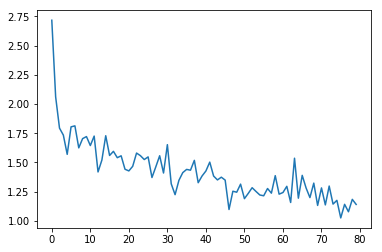

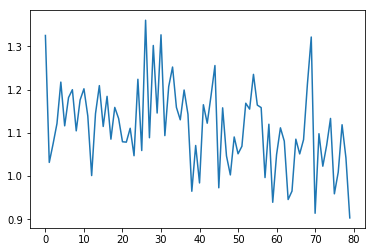

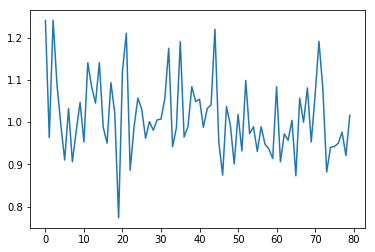

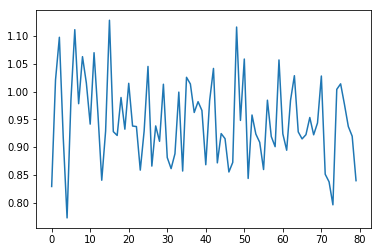

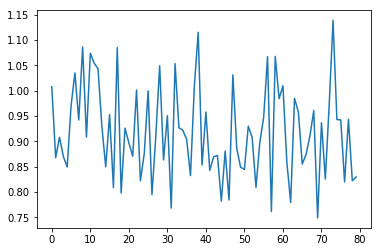

In [13]:
for i in range(num_epochs):
    plt.figure()
    plt.plot(allLosses[i])

## Testing

For testing purposes, again I have declared a simple function similar to [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). This time we do not need to worry about gradients and losses. We just need to forward pass through the network and find the output for a given nameTensor.


In [14]:
def evaluate(nameTensor):
    hidden = rnn.initHidden()

    for i in range(nameTensor.size()[0]):
        output, hidden = rnn(nameTensor[i], hidden)

    return output

### Calculating the accuracy of the model

In [15]:
correct=0
for example in testDataSet:
	nameTensor = nameToTensor(example[0])
	category = example[1]
	output = evaluate(nameTensor)
	guess, guess_i = categoryFromOutput(output)
	if guess == category:
		correct+=1

total = len(testDataSet)
accuracy = correct*100.0/total
print("Accuracy = "+str(accuracy))

Accuracy = 71.10834371108344
